In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Load Data

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
cols_to_drop = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df.drop(columns=cols_to_drop, inplace=True)
df.rename(columns={'job':'job_type', 'default':'default_status',
                                                            'housing':'housing_loan_status', 'loan':'personal_loan_status',
                                                            'contact':'contact_type', 'month':'contact_month',
                                                            'day_of_week':'contact_day_of_week','campaign':'num_contacts',
                                                            'pdays':'days_last_contact', 'previous':'previous_contacts',
                                                            'poutcome':'previous_outcome', 'y':'result'
                                                            }, inplace=True)

In [4]:
df['result'] = df['result'].map({'yes':1, 'no':0})

In [5]:
df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [7]:
df['result'].value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

In [8]:
X = df.drop(columns='result')
y = df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

# Build pipeline

In [ ]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, device='cuda')) # can customize objective function with the objective parameter NOTE: cuda only works with CuPy installed
]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

# Hyperparameter tuning

In [10]:
# Here's where Scikit Optimize comes in

search_space = {
    'clf__max_depth': Integer(2, 8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 1.0),
    'clf__reg_lambda': Real(0.0, 1.0),
    #'clf__reg_gamma': Real(0.0, 1.0),
}

opt = BayesSearchCV(
    pipe,
    search_space,
    cv = 3, # number of folds
    n_iter=10, # number of iterations aka number of hyper parameter settings
    random_state=8,
    scoring='roc_auc',
)
# in a real life scenario, you would want to tune more parameters and change the number of iterations



# Parameters for GPU support not possible with Pipeline

# Train the XGBoost model

In [ ]:
opt.fit(X_train, y_train)

c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:47:23] WARNING: D:\bld\xgboost-split_1730232589250\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device='cuda',
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

# Evaluation

In [12]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.9425384185492701,
                               colsample_bynode=0.9095956806239844,
                               colsample_bytree=0.706128679361455,
                               device='cuda', early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.003147342906395088, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))])

In [13]:
opt.best_score_

0.7641576000340417

In [14]:
opt.score(X_test, y_test)

0.7776777501297231

In [15]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
opt.predict_proba(X_test)

array([[0.8520207 , 0.14797932],
       [0.8563158 , 0.1436842 ],
       [0.85466063, 0.14533938],
       ...,
       [0.80370355, 0.19629647],
       [0.85946286, 0.14053717],
       [0.83834136, 0.16165861]], dtype=float32)

In [17]:
probabilitys = opt.predict_proba(X_test)

In [18]:
# feature importance
opt.best_estimator_.steps

[('encoder', TargetEncoder()),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.9425384185492701,
                colsample_bynode=0.9095956806239844,
                colsample_bytree=0.706128679361455, device='cuda',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.003147342906395088,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=8, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

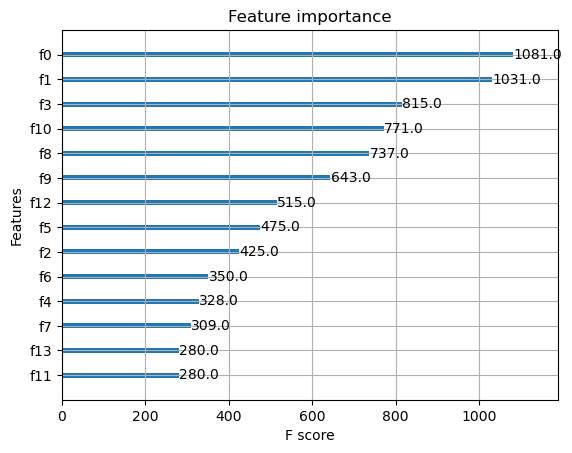

In [19]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)